In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
from torch import Tensor
from delaunay_rasterization.internal.alphablend_tiled_slang import render_alpha_blend_tiles_slang_raw
from scipy.spatial import Voronoi, Delaunay
from torch import nn
import matplotlib.pyplot as plt
import mediapy
import tinycudann as tcnn
from icecream import ic

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def get_slang_projection_matrix(znear, zfar, fy, fx, height, width, device):
    tanHalfFovX = width/(2*fx)
    tanHalfFovY = height/(2*fy)

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    z_sign = 1.0

    P = torch.tensor([
       [2.0 * znear / (right - left),     0.0,                          (right + left) / (right - left), 0.0 ],
       [0.0,                              2.0 * znear / (top - bottom), (top + bottom) / (top - bottom), 0.0 ],
       [0.0,                              0.0,                          z_sign * zfar / (zfar - znear),  -(zfar * znear) / (zfar - znear) ],
       [0.0,                              0.0,                          z_sign,                          0.0 ]
    ], device=device)

    return P

def common_camera_properties_from_gsplat(viewmats, Ks, height, width):
  """ Fetches all the Camera properties from the inria defined object"""
  zfar = 100.0
  znear = 0.01
  
  world_view_transform = viewmats
  fx = Ks[0,0]
  fy = Ks[1,1]
  projection_matrix = get_slang_projection_matrix(znear, zfar, fy, fx, height, width, Ks.device)
  fovx = focal2fov(fx, width)
  fovy = focal2fov(fy, height)

  cam_pos = viewmats.inverse()[:, 3]

  return world_view_transform, projection_matrix, cam_pos, fovy, fovx



/home/amai/delaunay_rasterization


/home/amai/micromamba/envs/gaussian_splatting/lib/python3.11/site-packages/tinycudann-1.7-py3.11-linux-x86_64.egg/tinycudann/modules.py:53: UserWarning: tinycudann was built for lower compute capability (86) than the system's (89). Performance may be suboptimal.
  warnings.warn(f"tinycudann was built for lower compute capability ({cc}) than the system's ({system_compute_capability}). Performance may be suboptimal.")


In [2]:
import os
import requests
import cv2

DownURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/350px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

img_data = requests.get(DownURL).content
with open('starry.jpg', 'wb') as handler:
    handler.write(img_data)

starry = cv2.imread("starry.jpg")
starry = cv2.cvtColor(starry, cv2.COLOR_BGR2RGB)

# Initialize scene

Parameter containing:
tensor([[ 0.5153, -0.4414, -0.1939],
        [ 0.4694, -0.9414,  0.5997],
        [-0.2057,  0.5087,  0.1390],
        ...,
        [ 0.7168,  0.3427, -0.8782],
        [ 0.6079, -0.0685, -0.5214],
        [ 0.4886, -0.5230,  0.1919]], device='cuda:0', requires_grad=True)
tensor(0.0508, device='cuda:0', grad_fn=<MaxBackward1>)


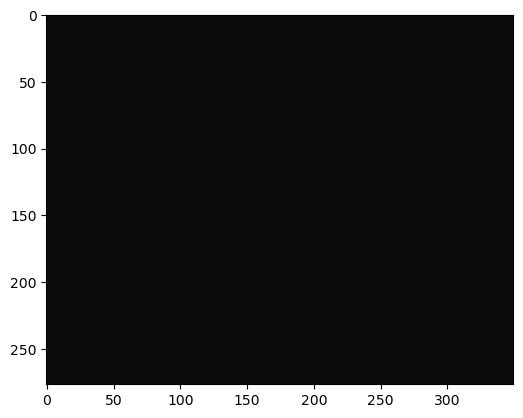

In [3]:
height = starry.shape[0]
width = starry.shape[1]
tile_size = 16
fov = 60

f = height / math.tan(fov * math.pi / 180 / 2.0);
K = torch.tensor([
  [f, 0, width/2],
  [0, f, height/2],
  [0, 0, 1],
])

viewmat = torch.eye(4)
viewmat[2, 3] = 2

torch.manual_seed(1)
N = 1600
vertices = (torch.rand((N, 3)) * 2 - 1)*1
v = Delaunay(vertices.numpy())

indices = torch.as_tensor(v.simplices).cuda()
vertices = nn.Parameter(vertices.cuda())
print(vertices)

num_freq = 5
net = nn.Sequential(
  nn.Linear(3*num_freq, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 4),
).cuda()

device = torch.device('cuda')
encoding = tcnn.Encoding(3, dict(
    otype="HashGrid",
    n_levels=16,
    n_features_per_level=2,
    log2_hashmap_size=14,
    base_resolution=1,
    per_level_scale=2
))
network = tcnn.Network(encoding.n_output_dims, 4, dict(
    otype="FullyFusedMLP",
    activation="ReLU",
    output_activation="None",
    n_neurons=64,
    n_hidden_layers=2,
))
net = torch.nn.Sequential(
    encoding, network
).to(device)

freq = 2**torch.arange(num_freq).cuda()
def safe_exp(x):
  return x.clip(max=5).exp()
# def rgbs_fn(xyz):
#   exyz = xyz.reshape(-1, 3, 1) * freq.reshape(1, -1).expand(1, 3, -1)
#   exy = torch.cos(exyz.reshape(-1, 3 * num_freq))
#   rgbs_raw = net(exy)
#   rgbs = torch.cat([torch.sigmoid(rgbs_raw[:, :3]), safe_exp(rgbs_raw[:, 3:])], dim=1)
#   return rgbs
def rgbs_fn(xyz):
  # exyz = xyz.reshape(-1, 3, 1) * freq.reshape(1, -1).expand(1, 3, -1)
  # exyz = contraction(exyz)
  # exy = safe_cos(exyz.reshape(-1, 3 * num_freq))
  # rgbs_raw = net(exy)
  rgbs_raw = net(xyz/10).float()
  rgbs = torch.cat([torch.sigmoid(rgbs_raw[:, :3]), safe_exp(rgbs_raw[:, 3:]-3)], dim=1)
  return rgbs


world_view_transform, projection_matrix, cam_pos, fovy, fovx = common_camera_properties_from_gsplat(viewmat, K, height, width)

render_pkg = render_alpha_blend_tiles_slang_raw(indices, vertices, rgbs_fn,
                                                world_view_transform.cuda(), K.cuda(), cam_pos.cuda(),
                                                fovy, fovx, height, width, tile_size=tile_size)

plt.imshow(render_pkg['render'].permute(1, 2, 0).detach().cpu().numpy())
print(render_pkg['render'].max())
plt.show()

# Match scene to starry night

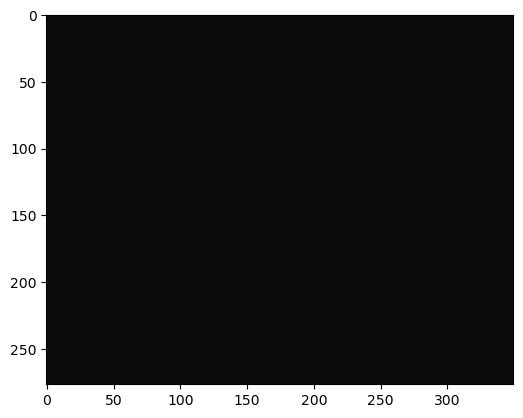

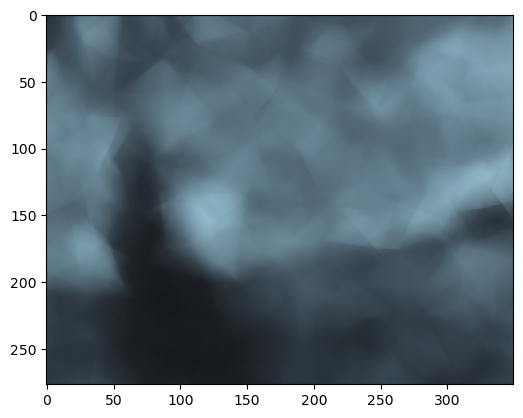

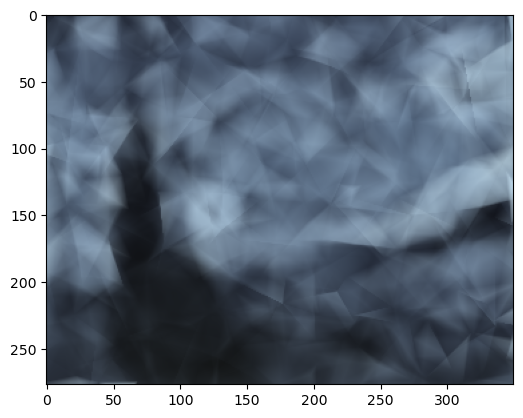

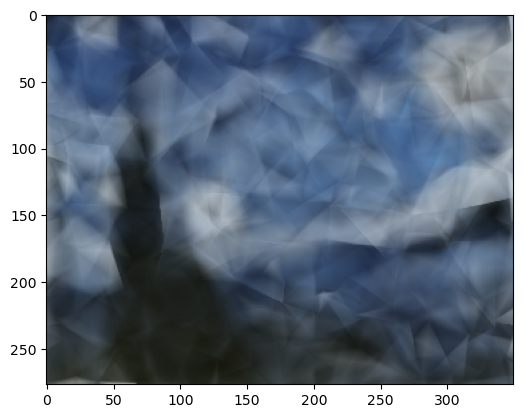

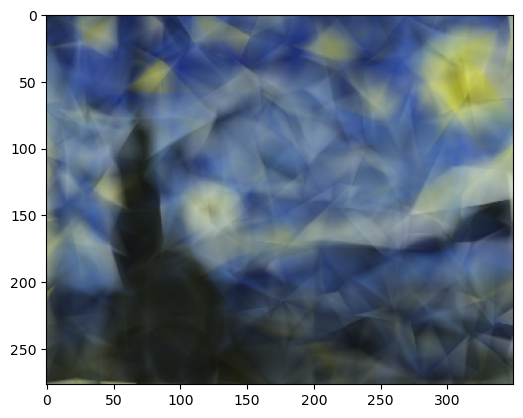

In [4]:
width, height = starry.shape[1], starry.shape[0]
starry_target = torch.as_tensor(starry).cuda() / 255
optim = torch.optim.Adam([
    {"params": net.parameters(), "lr": 5e-3},
    {"params": [vertices], "lr": 1e-3},
])
images = []
for i in range(201):
    optim.zero_grad()
    v = Delaunay(vertices.detach().cpu().numpy())

    indices = torch.as_tensor(v.simplices).cuda()
    render_pkg = render_alpha_blend_tiles_slang_raw(indices, vertices, rgbs_fn,
                                                    world_view_transform.cuda(), K.cuda(), cam_pos.cuda(),
                                                    fovy, fovx, height, width, tile_size=tile_size)

    image = render_pkg['render'].permute(1, 2, 0)
    loss = ((starry_target - image)**2).mean()
    image = image.detach().cpu().numpy()
    # ic(vertices)
    # print(loss)
    images.append(image)
    loss.backward()
    optim.step()
    if i % 50 == 0:
        plt.imshow(image)
        plt.show()
mediapy.show_video(images)

In [5]:

mediapy.show_video(images)